In [1]:
import os

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import cmcrameri.cm as cmc

import seaborn as sns

In [2]:
def myround(x, base=5):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [5]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [6]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [7]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [8]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', 'moment_before_peak', 'moment_after_peak'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type = 'fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    moment_before_peak = scipy.integrate.simpson(momentrate_opt[start:np.argmax(momentrate_opt)], dx = time_opt[1]-time_opt[0])
    moment_after_peak = scipy.integrate.simpson(momentrate_opt[np.argmax(momentrate_opt):end], dx = time_opt[1]-time_opt[0])

    mags = get_mag(scardec_name)
    int_mags = myround(mags, 0.5)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), moment_before_peak, moment_after_peak]
    results_db.loc[len(results_db)] = list_for_database


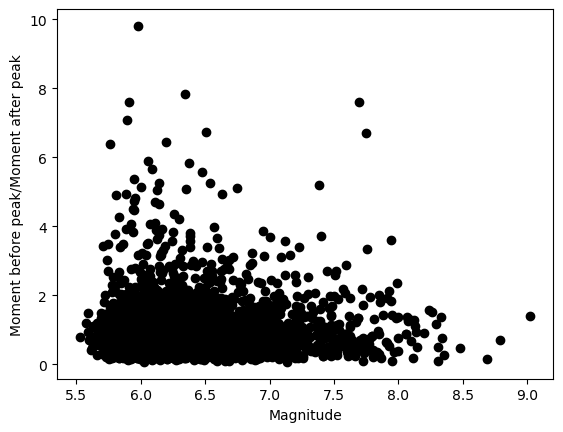

In [9]:
plt.scatter(results_db['magnitude'], results_db['moment_before_peak']/results_db['moment_after_peak'] , color = 'black')
plt.xlabel('Magnitude')
plt.ylabel('Moment before peak/Moment after peak')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/ratios_before_peak/ratio.png')

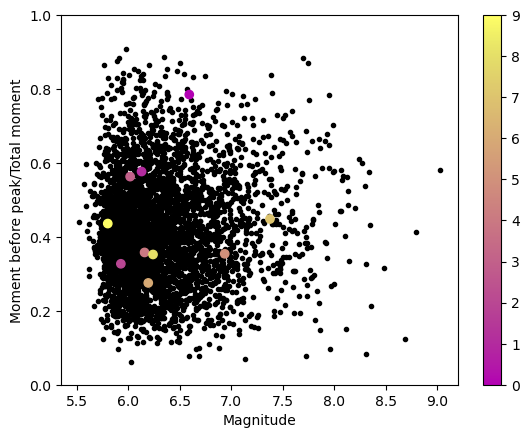

In [10]:
plt.scatter(results_db['magnitude'], results_db['moment_before_peak']/(results_db['moment_before_peak']+results_db['moment_after_peak']), color = 'black', marker = '.')
plt.xlabel('Magnitude')
plt.ylabel('Moment before peak/Total moment')
plt.ylim(0, 1)
plt.scatter(results_db['magnitude'].iloc[0:10],
            results_db['moment_before_peak'].iloc[0:10]/(results_db['moment_before_peak'].iloc[0:10]+results_db['moment_after_peak'].iloc[0:10]),
            cmap = cmc.buda,
            c = np.arange(0, 10))
plt.xlabel('Magnitude')
plt.ylabel('Moment before peak/Total moment')
plt.ylim(0, 1)
plt.colorbar()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/ratios_before_peak/ratio_with_first_10_highlighted.png')

In [16]:
for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec')[0:10]:
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type = 'fctmoy')

    plt.plot(time_opt, momentrate_opt, color = 'black')
    plt.scatter(time_opt[np.argmax(momentrate_opt)], max(momentrate_opt), color = 'navy', marker = 'x')
    plt.xlabel('Time (s)')
    plt.ylabel('Moment rate (Nm/s)')

    x_shade = np.linspace(min(time_opt), time_opt[np.argmax(momentrate_opt)], 100)
    y_shade = np.interp(x_shade, time_opt, momentrate_opt)
    plt.fill_between(x_shade, y_shade, color='navy', alpha=0.2)

    x_shade = np.linspace(time_opt[np.argmax(momentrate_opt)], max(time_opt), 100)
    y_shade = np.interp(x_shade, time_opt, momentrate_opt)
    plt.fill_between(x_shade, y_shade, color='hotpink', alpha=0.2)
    #plt.show()
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/ratios_before_peak/ratio_{scardec_name}.png')
    plt.close()


In [12]:
results_db['moment_ratio'] = results_db['moment_before_peak'] / (results_db['moment_before_peak'] + results_db['moment_after_peak'])

In [13]:
results_db.columns

Index(['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day',
       'moment_before_peak', 'moment_after_peak', 'moment_ratio'],
      dtype='object')

<Axes: xlabel='int_magnitude', ylabel='moment_ratio'>

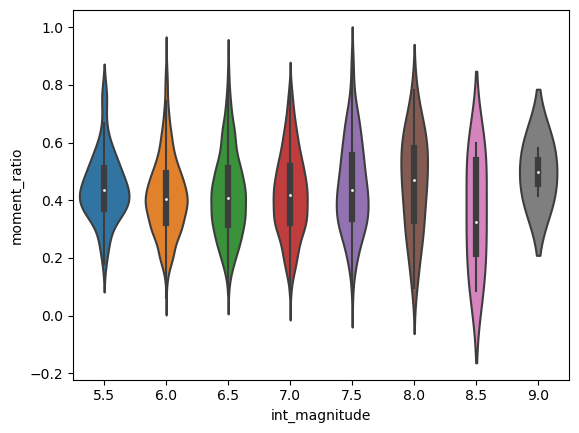

In [14]:
sns.violinplot(results_db, x = "int_magnitude", y = "moment_ratio")
# plt.xlabel('Magnitude')
# plt.ylabel('Moment before peak/Total moment')
# plt.ylim(0, 1)
# plt.scatter(results_db['magnitude'].iloc[0:10],
#             results_db['moment_before_peak'].iloc[0:10]/(results_db['moment_before_peak'].iloc[0:10]+results_db['moment_after_peak'].iloc[0:10]),
#             cmap = cmc.buda,
#             c = np.arange(0, 10))
# plt.xlabel('Magnitude')
# plt.ylabel('Moment before peak/Total moment')
# plt.ylim(0, 1)
# plt.colorbar()